# Testing out numerical solver code

## current setup
crank-nicholson gmres solver and pme cell diffusion 

## Objectives 
* i think to do this you'll need to do a sweep over induction start and end times for each sender type. do this by starting and stopping simulations, toggling xSa/b to 0 and back, then continuing. 
* scale the size of the colony too? put in a no-amplify control as well?

## Model considerations 



$$ \partial_t c = F(c)$$
$$ \partial_t c = (D_a+2D_c)\nabla^2c + 2D_c|\nabla c|^2+f(c)$$
Crank-Nicolson approach is to take 
$$ \frac{c_{n+1}-c_n}{\Delta t} = \frac{F(c_n)+F(c_{n+1})}{2} $$
When jacobian is available
$$ c_{n+1} = c_n + \Delta t \frac{F(c_n)+F(c_n) + J(c)(c_{n+1}-c_n))}{2} $$
$$ (1 - \Delta t J(c)/2) c_{n+1}  = (1 - \Delta t J(c_n)/2)c_n  + \Delta t F(c)$$
$$ (D_a+2D_c)\nabla^2c_n + 2D_c|\nabla c_n|^2+f(c_n) + (D_a+2D_c)\nabla^2c_{n+1} + 2D_c|\nabla c_{n+1}|^2+f(c_{n+1})$$
$$ c_{n-1} = c_n \Delta t ((D_a+2D_c)\nabla^2c + 2D_c|\nabla c|^2+f(c)) $$



In [1]:
# imports
from __future__ import division, print_function

import itertools as itt
import time

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

# %load_ext memory_profiler
# %load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

In [2]:
os.environ['OMP_NUM_THREADS'] = '8'

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Try to find out why solvers quit with too_small_step error

In [3]:
import importlib
from omnisim import null_omnisim as oms
oms = importlib.reload(oms)

In [4]:
# Params :    ,Dc,    rc,    rS,   rR,    Hn,Kn,   Dn,     kn,       Da,     xa,  xs,   xS,
p0 = np.array([1e-7,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, 1.6e-2, 2e-4, (1e-7), 250, 300,
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.02], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 1

cs_i, cn_i, cp_i, n_i, a_i, s_i, r_i  = np.arange(oms.species)
simmer = oms.Simulator(scale=16)
# simmer.set_scale(4)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [4]:
1/(Da*6*simmer.scale**2)

3.255208333333333

In [9]:
def new_init_conditions(simmer, n_spots=[1,1,100]):
    simmer.basedims = np.array([4,4])
    simmer.set_scale(simmer.scale)
    scale = simmer.scale
    simmer.t_eval = np.linspace(0,11*60*60,200)
    ns, nh, nw = simmer.initial_array.shape
    simmer.initial_array = np.zeros_like(simmer.initial_array)
    simmer.initial_array[n_i,:,:] = 100
    odval = 3e-3*simmer.scale**2
    r_vec = np.linspace(1e-3,0.7)*scale
    appx_distr = (r_vec)/np.sum(r_vec)
#     weights = np.array(weights)
#     n_ci_spots = n_spots*weights / np.sum(weights)
    ci_vec = oms.cell_inds
    for ci, ci_spots in zip(ci_vec, n_spots):
        for i in range(np.int(ci_spots)):
            r = np.random.choice(r_vec,1,p=appx_distr)
            theta = np.random.uniform(0,2*np.pi,size=(1,))
            x, y = np.int(r*np.cos(theta)+nw/2), np.int(r*np.sin(theta)+nh/2)
            simmer.initial_array[ci,y,x] = odval


In [10]:
new_init_conditions(simmer)

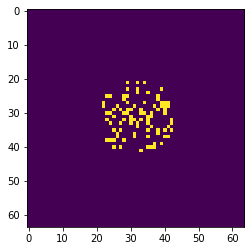

In [11]:
# species = 12
# cr_i, csa_i, csb_i, cpa_i, cpb_i, n_i, aa_i, ab_i, sa_i, sb_i, ra_i, rb_i = np.arange(species)
plt.imshow(simmer.initial_array[oms.cell_inds,:,:].sum(axis=0),interpolation='none')

In [13]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_2d_lineardiff as cn_gmres
cn_gmres = importlib.reload(cn_gmres)
# impexp = cn_gmres_2d.CNMGRK(simmer, 0, 2*60, first_step=5, rk_step=5e-2)

In [16]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()

sim_tmpl = './worker_outputs/null_{}_it{:0d}_wvi{:0d}.tif'
tvc_tmpl = './worker_outputs/null_{}_it{:0d}_wvi{:0d}_tvc.npy'
dt = 3
n_spots_vec = ((1,1,99),(1,10,90),(1,20,80),(1,50,50),(1,80,20),(1,99,1))
for wvi, n_spots in enumerate(n_spots_vec):
    for loop_i in np.arange(3,7):
        ns, nh, nw, _ = simmer.dims
        xs_vars = (('sa',250),('sr',0))
        new_init_conditions(simmer,n_spots=n_spots)
        for csnr, xs in xs_vars:        
            ys = []
            ts = []
            p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
            simmer.set_p0(p0)
            impexp = cn_gmres.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
            n_loops = np.int(14*3600/dt)
            rtime = time.time()
            for i in np.arange(n_loops):
                status, msg = impexp._step_impl()
                if status==False:
                    print(msg)
                    break
                if i%20:
                    continue
                else:
                    ys.append(impexp.y.copy())
                    ts.append(i*dt)
                if i%1000:
                    continue
                else:
                    print("completion:{:0.2f} dt:{}, loop:{}, cnsr:{}".format(i/n_loops,dt,loop_i,csnr))
                    print(dt*i/(time.time() - rtime))
            rtime = time.time() - rtime
            print("runtime:{:0.3f} minutes".format(rtime/60))
            species, nh, nw, dx = simmer.dims
            ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
            ys_stack = np.concatenate(ys_reshaped,axis=0)
            out_fn = sim_tmpl.format(csnr, loop_i, wvi)
            skimage.io.imsave(out_fn,ys_stack,plugin='tifffile')
            out_fn = tvc_tmpl.format(csnr, loop_i, wvi)
            np.save(out_fn, np.array(ts))
            print(out_fn)
    

completion:0.00 dt:3, loop:3, cnsr:sa
0.0
completion:0.06 dt:3, loop:3, cnsr:sa
52.57449421932019
completion:0.12 dt:3, loop:3, cnsr:sa
74.68133598870676
completion:0.18 dt:3, loop:3, cnsr:sa
96.60382253473466
completion:0.24 dt:3, loop:3, cnsr:sa
113.96644969279178
completion:0.30 dt:3, loop:3, cnsr:sa
127.61031679722545
completion:0.36 dt:3, loop:3, cnsr:sa
138.60987398523204
completion:0.42 dt:3, loop:3, cnsr:sa
148.17120811710637
completion:0.48 dt:3, loop:3, cnsr:sa
156.42286731656816
completion:0.54 dt:3, loop:3, cnsr:sa
163.4696294242864
completion:0.60 dt:3, loop:3, cnsr:sa
170.01753718231714
completion:0.65 dt:3, loop:3, cnsr:sa
175.7115094834512
completion:0.71 dt:3, loop:3, cnsr:sa
180.75941702293255
completion:0.77 dt:3, loop:3, cnsr:sa
185.28324803620714
completion:0.83 dt:3, loop:3, cnsr:sa
189.092228031163
completion:0.89 dt:3, loop:3, cnsr:sa
192.230194602084
completion:0.95 dt:3, loop:3, cnsr:sa
195.44518455962964
runtime:4.222 minutes
./worker_outputs/null_sa_it3_wvi0

completion:0.18 dt:3, loop:3, cnsr:sa
277.6938427696309
completion:0.24 dt:3, loop:3, cnsr:sa
277.2488326391295
completion:0.30 dt:3, loop:3, cnsr:sa
276.37962224099635
completion:0.36 dt:3, loop:3, cnsr:sa
275.6306669121164
completion:0.42 dt:3, loop:3, cnsr:sa
275.22842742789686
completion:0.48 dt:3, loop:3, cnsr:sa
275.87073206276375
completion:0.54 dt:3, loop:3, cnsr:sa
277.4152952377291
completion:0.60 dt:3, loop:3, cnsr:sa
278.18157461723655
completion:0.65 dt:3, loop:3, cnsr:sa
278.91673161059725
completion:0.71 dt:3, loop:3, cnsr:sa
279.8664786830168
completion:0.77 dt:3, loop:3, cnsr:sa
280.70746105860104
completion:0.83 dt:3, loop:3, cnsr:sa
281.43128142983085
completion:0.89 dt:3, loop:3, cnsr:sa
282.1100411642151
completion:0.95 dt:3, loop:3, cnsr:sa
281.7007566498749
runtime:2.977 minutes
./worker_outputs/null_sa_it3_wvi1_tvc.npy
completion:0.00 dt:3, loop:3, cnsr:sr
0.0
completion:0.06 dt:3, loop:3, cnsr:sr
287.7921240284546
completion:0.12 dt:3, loop:3, cnsr:sr
302.14726

completion:0.36 dt:3, loop:3, cnsr:sa
305.37317728427524
completion:0.42 dt:3, loop:3, cnsr:sa
305.127329602623
completion:0.48 dt:3, loop:3, cnsr:sa
303.87581025827177
completion:0.54 dt:3, loop:3, cnsr:sa
303.39135054243127
completion:0.60 dt:3, loop:3, cnsr:sa
302.7724037619586
completion:0.65 dt:3, loop:3, cnsr:sa
302.40537803409836
completion:0.71 dt:3, loop:3, cnsr:sa
302.0148368416418
completion:0.77 dt:3, loop:3, cnsr:sa
301.8882644217677
completion:0.83 dt:3, loop:3, cnsr:sa
301.80989909640965
completion:0.89 dt:3, loop:3, cnsr:sa
301.49940201920856
completion:0.95 dt:3, loop:3, cnsr:sa
301.5742631756795
runtime:2.785 minutes
./worker_outputs/null_sa_it3_wvi2_tvc.npy
completion:0.00 dt:3, loop:3, cnsr:sr
0.0
completion:0.06 dt:3, loop:3, cnsr:sr
303.9454756217139
completion:0.12 dt:3, loop:3, cnsr:sr
306.8323891784583
completion:0.18 dt:3, loop:3, cnsr:sr
309.64684255420457
completion:0.24 dt:3, loop:3, cnsr:sr
309.8026504783247
completion:0.30 dt:3, loop:3, cnsr:sr
309.886633

completion:0.54 dt:3, loop:3, cnsr:sa
202.04064854989724
completion:0.60 dt:3, loop:3, cnsr:sa
203.42314481373657
completion:0.65 dt:3, loop:3, cnsr:sa
205.24811502926661
completion:0.71 dt:3, loop:3, cnsr:sa
207.07655063722345
completion:0.77 dt:3, loop:3, cnsr:sa
208.75450774086676
completion:0.83 dt:3, loop:3, cnsr:sa
210.5611270719997
completion:0.89 dt:3, loop:3, cnsr:sa
212.24061451961867
completion:0.95 dt:3, loop:3, cnsr:sa
213.56609524486896
runtime:3.920 minutes
./worker_outputs/null_sa_it3_wvi3_tvc.npy
completion:0.00 dt:3, loop:3, cnsr:sr
0.0
completion:0.06 dt:3, loop:3, cnsr:sr
186.3500195888814
completion:0.12 dt:3, loop:3, cnsr:sr
194.57812903493328
completion:0.18 dt:3, loop:3, cnsr:sr
207.57520115727792
completion:0.24 dt:3, loop:3, cnsr:sr
213.94306075513637
completion:0.30 dt:3, loop:3, cnsr:sr
220.8493160607074
completion:0.36 dt:3, loop:3, cnsr:sr
227.748665797609
completion:0.42 dt:3, loop:3, cnsr:sr
232.59211292773173
completion:0.48 dt:3, loop:3, cnsr:sr
234.95

completion:0.71 dt:3, loop:3, cnsr:sa
278.8765143644923
completion:0.77 dt:3, loop:3, cnsr:sa
278.53350510983205
completion:0.83 dt:3, loop:3, cnsr:sa
278.1954243302735
completion:0.89 dt:3, loop:3, cnsr:sa
277.9351737078711
completion:0.95 dt:3, loop:3, cnsr:sa
277.75794554897675
runtime:3.026 minutes
./worker_outputs/null_sa_it3_wvi4_tvc.npy
completion:0.00 dt:3, loop:3, cnsr:sr
0.0
completion:0.06 dt:3, loop:3, cnsr:sr
285.4475774682081
completion:0.12 dt:3, loop:3, cnsr:sr
291.9106996169176
completion:0.18 dt:3, loop:3, cnsr:sr
295.9890997090114
completion:0.24 dt:3, loop:3, cnsr:sr
298.2797673283018
completion:0.30 dt:3, loop:3, cnsr:sr
299.7962376769554
completion:0.36 dt:3, loop:3, cnsr:sr
300.93107765169856
completion:0.42 dt:3, loop:3, cnsr:sr
301.59975475746114
completion:0.48 dt:3, loop:3, cnsr:sr
301.9648539057518
completion:0.54 dt:3, loop:3, cnsr:sr
302.7757760338818
completion:0.60 dt:3, loop:3, cnsr:sr
303.5527946449487
completion:0.65 dt:3, loop:3, cnsr:sr
304.12571400

completion:0.89 dt:3, loop:3, cnsr:sa
305.35564395852066
completion:0.95 dt:3, loop:3, cnsr:sa
305.39454163660434
runtime:2.752 minutes
./worker_outputs/null_sa_it3_wvi5_tvc.npy
completion:0.00 dt:3, loop:3, cnsr:sr
0.0
completion:0.06 dt:3, loop:3, cnsr:sr
302.72423402510424
completion:0.12 dt:3, loop:3, cnsr:sr
303.0217984323816
completion:0.18 dt:3, loop:3, cnsr:sr
303.314264846943
completion:0.24 dt:3, loop:3, cnsr:sr
304.363235813337
completion:0.30 dt:3, loop:3, cnsr:sr
305.47720551411504
completion:0.36 dt:3, loop:3, cnsr:sr
306.5775313474246
completion:0.42 dt:3, loop:3, cnsr:sr
307.4701924342402
completion:0.48 dt:3, loop:3, cnsr:sr
307.85068970761984
completion:0.54 dt:3, loop:3, cnsr:sr
308.35132633779597
completion:0.60 dt:3, loop:3, cnsr:sr
308.68380824888925
completion:0.65 dt:3, loop:3, cnsr:sr
307.8230211966765
completion:0.71 dt:3, loop:3, cnsr:sr
308.2898339166638
completion:0.77 dt:3, loop:3, cnsr:sr
308.7182160989669
completion:0.83 dt:3, loop:3, cnsr:sr
309.1751403

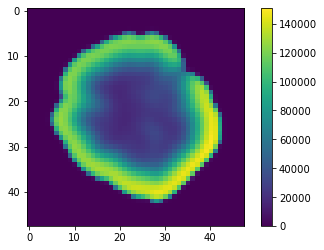

In [46]:
plt.imshow(ys_stack[-1,oms.rep_inds,...].sum(axis=0))#-ys_stack[-1,[cr_i,rb_i],...].prod(axis=0))
plt.colorbar()

In [47]:
import skimage.io
img1 = skimage.io.imread('worker_outputs/smallpads_sa_it2.tif')
img2 = skimage.io.imread('worker_outputs/smallpads_sr_it2.tif')

In [5]:

def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(6)
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,3, figsize=(10,7))
    axs = axs.flatten()
    im_list = [0,0,0,0,0,0]
    
    # Plot cell densities
    ax_ind = 0
    ax = axs[ax_ind]
    indxs = [cp_i, cs_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[ax_ind] = im
    
    # Plot nutrient densities
    ax_ind = 1
    ax = axs[ax_ind]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[ax_ind] = im
    
    # Plot pulser synthase densities
    ax_ind = 2
    ax = axs[ax_ind]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    indxs = [s_i, cs_i]
    v_arr += im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[ax_ind] = im
    
    # Plot ahl conc
    ax_ind = 3
    ax = axs[ax_ind]
    indxs = [a_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('ahl')
    im_list[ax_ind] = im
    
    # Plot pulser repressor densities
    ax_ind = 4
    ax = axs[ax_ind]
    indxs = [r_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('repr')
    im_list[ax_ind] = im
    
    # Plot total cellular protein
    ax_ind = 5
    ax = axs[ax_ind]
    indxs = [s_i, r_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cellular protein')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        indxs = [s_i, cs_i]
        frame_arr += im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)
        
        # Plot ahl
        ax = axs[3]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot repr
        ax = axs[4]
        indxs = [cp_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[4].set_array(frame_arr)

        # Plot cellular protein
        ax = axs[5]
        indxs = [s_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
#     fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A



In [52]:
from omnisim.chain_omnisim import species 
# cs_i, cra_i, crb_i, crc_i, crd_i, cp_i, n_i, aa_i, ab_i, ac_i, ad_i, sa_i, sb_i, sc_i, sd_i, ra_i, rb_i, rc_i, rd_i  = np.arange(species)
# cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(6)
cs_i, cn_i, cp_i, n_i, a_i, s_i, r_i = np.arange(7)
import skimage.io
img1 = skimage.io.imread('worker_outputs/null_sa_it0_wvi0.tif')
img2 = skimage.io.imread('worker_outputs/null_sr_it0_wvi0.tif')

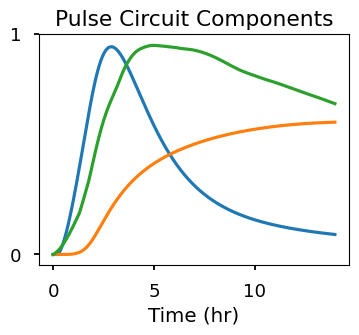

In [84]:
plt.style.use('default')
plt.style.use('seaborn-talk')
fig = plt.figure(figsize=(4,3))
t_vec = np.arange(img1.shape[0])/60
plt.plot(t_vec,img1[:,[cp_i,s_i],26,26].prod(axis=1)/2e5,label='Synthase')
plt.plot(t_vec,img1[:,[cp_i,r_i],26,26].prod(axis=1)/4e4,label='Repressor')
plt.plot(t_vec,img1[:,[a_i],26,26].prod(axis=1)/120,label='Signal Molecule')
plt.xlabel('Time (hr)')
plt.title('Pulse Circuit Components')
plt.yticks([0,1])
# plt.ylim([])
fig.savefig('figs/circ_norm.png',transparent=True,dpi=110)
fig.savefig('figs/circ_norm.pdf',transparent=True,dpi=110)
# plt.legend()

In [25]:
anim = write_movie(img1[:,[cs_i,cp_i, n_i, a_i, s_i, r_i],...],np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [26]:
anim = write_movie(img2[:,[cs_i,cp_i, n_i, a_i, s_i, r_i],...],np.arange(img2.shape[0]))
HTML(anim.to_html5_video())

In [53]:
anim = write_movie(ys_stack[:,[cs_i,cp_i,n_i,aa_i,sa_i,ra_i],...],np.arange(ys_stack.shape[0]))
HTML(anim.to_html5_video())

In [54]:
anim = write_movie(ys_stack[:,[cra_i,cp_i,n_i,ab_i,sb_i,rb_i],...],np.arange(ys_stack.shape[0]))
HTML(anim.to_html5_video())

In [55]:
anim = write_movie(ys_stack[:,[crb_i,cp_i,n_i,ac_i,sc_i,rc_i],...],np.arange(ys_stack.shape[0]))
HTML(anim.to_html5_video())

In [56]:
anim = write_movie(ys_stack[:,[crc_i,cp_i,n_i,ad_i,sd_i,rd_i],...],np.arange(ys_stack.shape[0]))
HTML(anim.to_html5_video())

In [51]:
anim = write_movie(img2,np.arange(img2.shape[0]))
HTML(anim.to_html5_video())

In [65]:
grid_volume = (1/scale)**3 # mm^3
layer_amount = img2[-1,a_i,...].sum()*grid_volume # nM * mm^3
full_pad_amount = layer_amount*(2*scale) # upper bound, assumes no gradient
full_pad_conc = full_pad_amount / (2*scale*(64/scale)**2)
print(full_pad_conc)
# 32*((img1[-1,a_i,...].sum()-0*img2[-1,a_i,...].sum())*1e-3*(1e-1/16)**3)/1e-3

2.5853838480207436


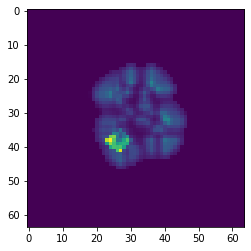

In [71]:
plt.imshow(img1[-5,[s_i,cp_i],:,:].prod(axis=0))

In [6]:
import skimage.io

sim_tmpl = './worker_outputs/null_{}_it{:0d}_wvi{:0d}.tif'
tvc_tmpl = './worker_outputs/null_{}_it{:0d}_wvi{:0d}_tvc.npy'
dt = 3
n_spots_vec = ((1,1,99),(1,10,90),(1,20,80),(1,50,50),(1,80,20),(1,99,1))
wvi_vec = np.arange(len(n_spots_vec))
loop_vec = np.arange(7)

def load_imgs(wvi, li, csnr):
    sim_fn = sim_tmpl.format(csnr,li,wvi)
    img = skimage.io.imread(sim_fn)
    return img



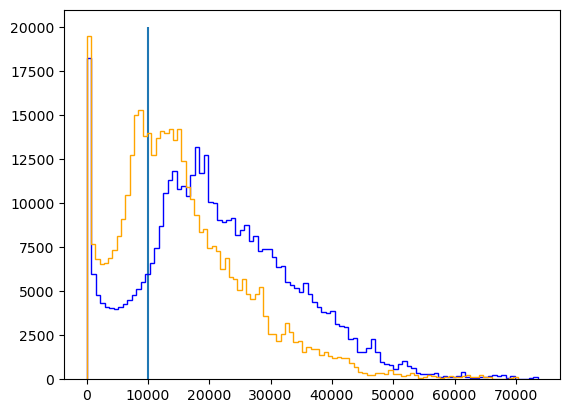

In [39]:
wvi, li = 0,3
img1 = load_imgs(wvi, li,'sa')
img2 = load_imgs(wvi, li,'sr')
rep_vec1 = img1[:,[cp_i,r_i],...].prod(axis=1)
bool_vec = img1[:,cp_i,...] > 0.5
rep_vec2 = img2[:,[cp_i,r_i],...].prod(axis=1)
bool_vec = (img2[:,cp_i,...] > 0.5)&bool_vec
rep_vec = rep_vec1[bool_vec].flatten() - rep_vec2[bool_vec].flatten()
_ = plt.hist(rep_vec1[bool_vec].flatten(), histtype='step',bins=100,color='blue')
_ = plt.hist(rep_vec2[bool_vec].flatten(), histtype='step',bins=100,color='orange')
plt.vlines(np.power(10,4),0,2e4)

In [9]:
df_list = []
for wvi in wvi_vec:
    for li in loop_vec:
        img1 = load_imgs(wvi, li,'sa')
        img2 = load_imgs(wvi, li,'sr')
        rep_vec1 = img1[:,[cp_i,r_i],...].prod(axis=1)
        bool_vec = img1[:,cp_i,...] > 0.5
        rep_vec2 = img2[:,[cp_i,r_i],...].prod(axis=1)
        bool_vec = (img2[:,cp_i,...] > 0.5)&bool_vec
        rep_vec = rep_vec1[bool_vec].flatten() - rep_vec2[bool_vec].flatten()
        df = pd.DataFrame({'fluor':rep_vec})
        df['iter'] = li
        df['wvi'] = wvi
        df_list.append(df)
all_df = pd.concat(df_list, ignore_index=True)

In [16]:
sub_df = all_df.loc[(all_df.fluor.values>10),:].copy()

In [43]:
yticks = np.arange(0.5,-3.5,-0.5)
# g.set_yticks(yticks)
labels = []
for ytick in yticks:
    if (ytick%1)<0.2:
        if ytick==0:
            labels.append("1")
        else:
            labels.append("1/{:d}".format(np.int(10**np.abs(ytick))))
    else:
        labels.append('')
print(labels)
# g.set_yticks(np.arange(0.5,-3.5,-0.5))

['', '1', '', '1/10', '', '1/100', '', '1/1000']


In [85]:
len(labels)

8

[Text(0, 0.5, ''),
 Text(0, 0.0, '1'),
 Text(0, -0.5, ''),
 Text(0, -1.0, '1/10'),
 Text(0, -1.5, ''),
 Text(0, -2.0, '1/100'),
 Text(0, -2.5, ''),
 Text(0, -3.0, '1/1000')]

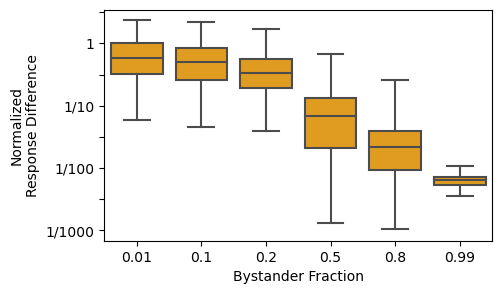

In [50]:
import seaborn as sns
plt.style.use('default')
plt.style.use('fast')
sub_df['logfluor'] = np.log10(sub_df.fluor.values)
wvi_dict = dict(zip(wvi_vec,[0.01,0.1,0.2,0.5,0.8,0.99]))
conv_wvi = lambda x : wvi_dict[x]
sub_df['Bystander Fraction'] = sub_df.wvi.apply(conv_wvi)
sub_df['Normalized\nResponse Difference'] = sub_df.logfluor-4
fig, ax = plt.subplots(1,1,figsize=(5,3))
g = sns.boxplot(x="Bystander Fraction", y='Normalized\nResponse Difference',
                data=sub_df,ax=ax,color='orange',fliersize=0);
yticks = np.arange(0.5,-3.5,-0.5)
labels = []
for ytick in yticks:
    if (ytick%1)<0.2:
        if ytick==0:
            labels.append("1")
        else:
            labels.append("1/{:d}".format(np.int(10**np.abs(ytick))))
    else:
        labels.append('')
g.set_yticks(yticks)
g.set_yticklabels(labels)

[Text(0, 0.5, ''),
 Text(0, 0.0, '1'),
 Text(0, -0.5, ''),
 Text(0, -1.0, '1/10'),
 Text(0, -1.5, ''),
 Text(0, -2.0, '1/100'),
 Text(0, -2.5, ''),
 Text(0, -3.0, '1/1000')]

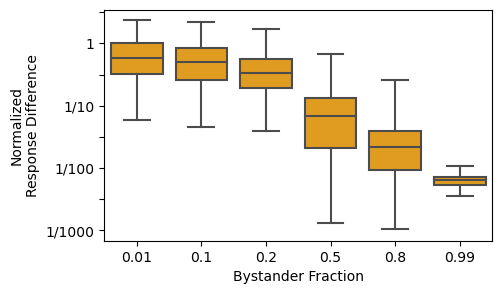

In [89]:
import seaborn as sns
plt.style.use('default')
plt.style.use('fast')
sub_df['logfluor'] = np.log10(sub_df.fluor.values)
wvi_dict = dict(zip(wvi_vec,[0.01,0.1,0.2,0.5,0.8,0.99]))
conv_wvi = lambda x : wvi_dict[x]
sub_df['Bystander Fraction'] = sub_df.wvi.apply(conv_wvi)
sub_df['Normalized\nResponse Difference'] = sub_df.logfluor-4
fig, ax = plt.subplots(1,1,figsize=(5,3))
g = sns.boxplot(x="Bystander Fraction", y='Normalized\nResponse Difference',
                data=sub_df,ax=ax,color='orange',fliersize=0);
yticks = np.arange(0.5,-3.5,-0.5)
labels = []
for ytick in yticks:
    if (ytick%1)<0.2:
        if ytick==0:
            labels.append("1")
        else:
            labels.append("1/{:d}".format(np.int(10**np.abs(ytick))))
    else:
        labels.append('')
g.set_yticks(yticks)
g.set_yticklabels(labels)

In [90]:
fig.tight_layout()
fig.savefig('figs/null_comp.png',transparent=True,dpi=180)
fig.savefig('figs/null_comp.pdf',transparent=True,dpi=180)